In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from gensim.models import LdaModel, LsiModel, TfidfModel, Word2Vec, FastText, Doc2Vec
from gensim.corpora.dictionary import Dictionary
import re
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from gensim.matutils import corpus2dense

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/portnovaxenia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/portnovaxenia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
nltk.__version__

'3.8.1'

In [4]:
df = pd.read_csv('legal_text_corpus.csv')
df.columns = ['Name','Link','Text','Comment','Data']
df

,Name,Link,Text,Comment,Data
0,Указ временно исполняющего обязанности главы Д...,https://rg.ru/documents/2022/11/28/dnr-ukaz37-...,1. Внести в Указ временно исполняющего обязанн...,Врио главы ДНР Денис Пушилин подписал указ об ...,2022-11-28
1,Постановление Конституционного Суда Российской...,https://rg.ru/documents/2022/11/25/document-ob...,Именем Российской Федерации Конституционный С...,"Бессрочный запрет на профессию для адвокатов, ...",2022-11-25
2,Постановление Пленума Верховного Суда Российск...,https://rg.ru/documents/2022/11/25/document-pl...,В целях обеспечения единства практики применен...,Пленум Верховного суда России утвердил постано...,2022-11-25
3,Федеральный закон от 21 ноября 2022 г. N 443-Ф...,https://rg.ru/documents/2022/11/24/document-na...,Принят Государственной Думой 10 ноября 2022 го...,На сладкую газировку с 1 июля 2023 года введут...,2022-11-24
4,Федеральный закон от 21 ноября 2022 г. N 448-Ф...,https://rg.ru/documents/2022/11/24/document-by...,Принят Государственной Думой 10 ноября 2022 го...,Приостановленное в этом году бюджетное правило...,2022-11-24
...,...,...,...,...,...
2958,Постановление о совершенствовании госрегулиров...,https://rg.ru/2009/08/14/lekarstva-dok.html,Правительство Российской Федерации постановляе...,Производители жизненно необходимых и важнейших...,2009-08-14
2959,"Правила оплаты проезда осужденных, самостоятел...",https://rg.ru/2009/08/12/pravila-dok.html,В соответствии с частью второй статьи 751 Угол...,"Правительство утвердило новые правила, как опл...",2009-08-12
2960,Изменения в постановление правительства о него...,https://rg.ru/2009/08/07/sysk-izmenenia-dok.html,Правительство Российской Федерации постановляе...,Частные охранники и детективы должны будут про...,2009-08-20
2961,Постановление Главного госсанврача о надзоре з...,https://rg.ru/2009/08/05/bad-dok.html,Зарегистрирован в Минюсте РФ 10 июля 2009 г. ...,В России усилят контроль за производством и об...,2009-08-20


In [6]:
def process_text(text):
    stop_words = set(stopwords.words('russian'))
    morph = MorphAnalyzer()

    # Токенизация текста
    tokens = word_tokenize(text)
    # Оставляем только буквенные токены
    tokens = [word for word in tokens if word.isalpha()]
    # Приводим все токены к нижнему регистру
    tokens = [word.lower() for word in tokens]
    # Удаляем стоп-слова
    tokens = [word for word in tokens if not word in stop_words]
    # Лемматизация токенов
    tokens = [morph.normal_forms(word)[0] for word in tokens]

    return tokens

In [7]:
def join_list(tab):
    return " ".join((''.join(l) for l in tab))

In [9]:
tokens = df['Text']
tokens = tokens.apply(lambda token: process_text(token))
tokens = [[token for token in sublist if token not in ['ст', 'n']] for sublist in tokens]
tokens = pd.Series(tokens)
df['Tokens'] = tokens
df["Text_preprocessed"] = tokens.apply(join_list)

In [23]:
mydict = Dictionary(df['Tokens'])
corpus = [mydict.doc2bow(text) for text in df['Tokens']]
tf_model = TfidfModel(corpus) 
corpus_tf = tf_model[corpus]  
lsi_model = LsiModel(corpus_tf, id2word=mydict, num_topics=30)

In [24]:
lsi_model.show_topics(num_topics=5, num_words=10, formatted=False)

[(0,
  [('слово', 0.22498367942784991),
   ('тысяча', 0.12751845265292266),
   ('статья', 0.1264731855970039),
   ('часть', 0.11759718195925586),
   ('военный', 0.1172779193092611),
   ('административный', 0.11350828315664478),
   ('суд', 0.10730627121350061),
   ('налоговый', 0.10351962948115191),
   ('орган', 0.10094409411404234),
   ('служба', 0.09997412199718289)]),
 (1,
  [('военный', -0.464009564928743),
   ('тысяча', 0.37474864721511636),
   ('служба', -0.3060592118688893),
   ('воинский', -0.2322372376489784),
   ('призыв', -0.20754221965100295),
   ('слово', 0.18339487531263626),
   ('административный', 0.17468331491326528),
   ('рубль', 0.16488525677461552),
   ('военнослужащий', -0.11239182933466745),
   ('штраф', 0.11219401947818815)]),
 (2,
  [('тысяча', 0.4309019262323266),
   ('военный', 0.3985341333362262),
   ('служба', 0.22564802060541286),
   ('воинский', 0.2109308831241841),
   ('призыв', 0.19723562275508663),
   ('административный', 0.16266189377528967),
   ('слово

In [25]:
text = lsi_model[corpus]

In [26]:
topic_ids = [max(vector, key=lambda item: item[1])[0] for vector in text]

In [27]:
df['Topic_byText'] = topic_ids

In [18]:
df['Topic_byText'].value_counts()

0     2662
1       60
10      45
18      27
2       26
8       25
12      25
6       24
15      17
3       17
7       10
5       10
19      10
13       3
17       2
Name: Topic_byText, dtype: int64

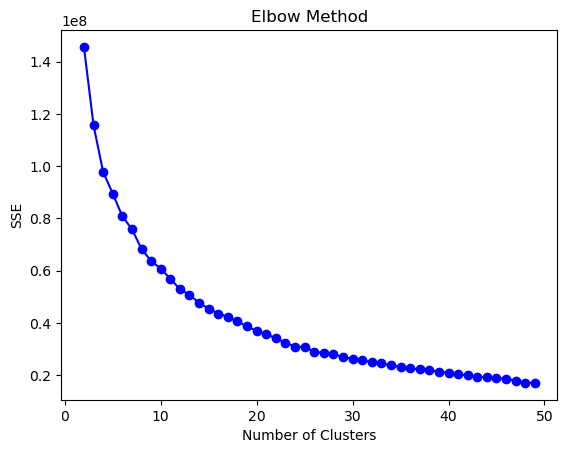

In [22]:
feature_matrix = corpus2dense(lsi_model[corpus], num_terms=lsi_model.num_topics).T
k_values = range(2, 50)

sse_values = []

for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init = 10)
    kmeans_model.fit(feature_matrix)
    sse_values.append(kmeans_model.inertia_)

plt.plot(k_values, sse_values, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()



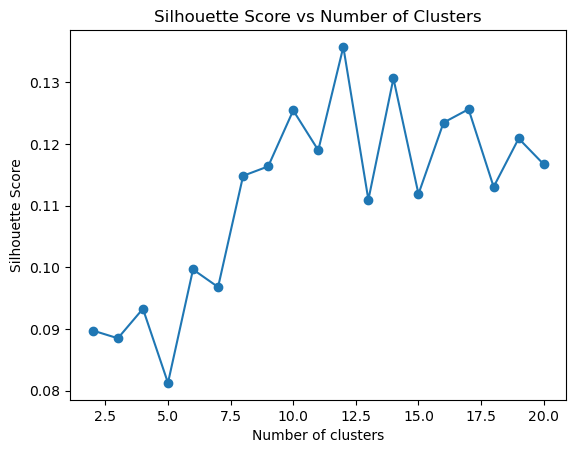

In [113]:
name = df['Name'].apply(lambda text: process_text(text))
name = pd.Series(name)
name = name.apply(join_list)

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5)
tfidf_matrix = tfidf_vectorizer.fit_transform(name)
lsi_model = TruncatedSVD(n_components=100)  
lsi_vectors = lsi_model.fit_transform(tfidf_matrix)

silhouette_scores = []
max_clusters = 20
for n_clusters in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(lsi_vectors)
    silhouette_avg = silhouette_score(lsi_vectors, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()


In [114]:
kmeans = KMeans(n_clusters=12, random_state=42, n_init = 10)
cluster_labels = kmeans.fit_predict(lsi_vectors)

df['Topic_byName'] = cluster_labels
df


,Name,Link,Text,Comment,Data,Tokens,Text_preprocessed,Topic_byText,Action,Expired,Topic_byName
0,Указ временно исполняющего обязанности главы Д...,https://rg.ru/documents/2022/11/28/dnr-ukaz37-...,1. Внести в Указ временно исполняющего обязанн...,Врио главы ДНР Денис Пушилин подписал указ об ...,2022-11-28,"[внести, указ, временно, исполнять, обязанност...",внести указ временно исполнять обязанность гла...,10,NaN,NaN,1
1,Постановление Конституционного Суда Российской...,https://rg.ru/documents/2022/11/25/document-ob...,Именем Российской Федерации Конституционный С...,"Бессрочный запрет на профессию для адвокатов, ...",2022-11-25,"[имя, российский, федерация, конституционный, ...",имя российский федерация конституционный суд р...,0,Рассмотрение,NaN,2
2,Постановление Пленума Верховного Суда Российск...,https://rg.ru/documents/2022/11/25/document-pl...,В целях обеспечения единства практики применен...,Пленум Верховного суда России утвердил постано...,2022-11-25,"[цель, обеспечение, единство, практика, примен...",цель обеспечение единство практика применение ...,0,Разъяснение,NaN,11
3,Федеральный закон от 21 ноября 2022 г. N 443-Ф...,https://rg.ru/documents/2022/11/24/document-na...,Принят Государственной Думой 10 ноября 2022 го...,На сладкую газировку с 1 июля 2023 года введут...,2022-11-24,"[принять, государственный, дума, ноябрь, год, ...",принять государственный дума ноябрь год одобри...,0,Изменение,NaN,8
4,Федеральный закон от 21 ноября 2022 г. N 448-Ф...,https://rg.ru/documents/2022/11/24/document-by...,Принят Государственной Думой 10 ноября 2022 го...,Приостановленное в этом году бюджетное правило...,2022-11-24,"[принять, государственный, дума, ноябрь, год, ...",принять государственный дума ноябрь год одобри...,0,Изменение,"Федерального закона ""Об особенностях эмиссии и...",4
...,...,...,...,...,...,...,...,...,...,...,...
2958,Постановление о совершенствовании госрегулиров...,https://rg.ru/2009/08/14/lekarstva-dok.html,Правительство Российской Федерации постановляе...,Производители жизненно необходимых и важнейших...,2009-08-14,"[правительство, российский, федерация, постано...",правительство российский федерация постановлят...,0,Разъяснение,NaN,1
2959,"Правила оплаты проезда осужденных, самостоятел...",https://rg.ru/2009/08/12/pravila-dok.html,В соответствии с частью второй статьи 751 Угол...,"Правительство утвердило новые правила, как опл...",2009-08-12,"[соответствие, часть, второй, статья, кодекс, ...",соответствие часть второй статья кодекс россий...,0,NaN,NaN,1
2960,Изменения в постановление правительства о него...,https://rg.ru/2009/08/07/sysk-izmenenia-dok.html,Правительство Российской Федерации постановляе...,Частные охранники и детективы должны будут про...,2009-08-20,"[правительство, российский, федерация, постано...",правительство российский федерация постановлят...,0,NaN,NaN,1
2961,Постановление Главного госсанврача о надзоре з...,https://rg.ru/2009/08/05/bad-dok.html,Зарегистрирован в Минюсте РФ 10 июля 2009 г. ...,В России усилят контроль за производством и об...,2009-08-20,"[зарегистрировать, минюст, рф, июль, регистрац...",зарегистрировать минюст рф июль регистрационны...,0,Постановление,NaN,1


In [115]:
df['Topic_byName'].value_counts()

1     1322
9      476
4      287
10     183
5      165
8      114
2      110
3      101
11      99
6       44
0       38
7       24
Name: Topic_byName, dtype: int64

In [120]:
import spacy
import ru_core_news_sm

nlp = ru_core_news_sm.load()

def extract_organization(text):
    doc = nlp(text)
    organizations = [ent.text for ent in doc.ents if ent.label_ == 'ORG']
    return organizations[0] if organizations else None

df['Author'] = df['Text'].apply(extract_organization)


df

,Name,Link,Text,Comment,Data,Tokens,Text_preprocessed,Topic_byText,Action,Expired,Topic_byName,Found_Law_Names,Author
0,Указ временно исполняющего обязанности главы Д...,https://rg.ru/documents/2022/11/28/dnr-ukaz37-...,1. Внести в Указ временно исполняющего обязанн...,Врио главы ДНР Денис Пушилин подписал указ об ...,2022-11-28,"[внести, указ, временно, исполнять, обязанност...",внести указ временно исполнять обязанность гла...,10,NaN,NaN,1,,None
1,Постановление Конституционного Суда Российской...,https://rg.ru/documents/2022/11/25/document-ob...,Именем Российской Федерации Конституционный С...,"Бессрочный запрет на профессию для адвокатов, ...",2022-11-25,"[имя, российский, федерация, конституционный, ...",имя российский федерация конституционный суд р...,0,Рассмотрение,NaN,2,,Конституционный Суд
2,Постановление Пленума Верховного Суда Российск...,https://rg.ru/documents/2022/11/25/document-pl...,В целях обеспечения единства практики применен...,Пленум Верховного суда России утвердил постано...,2022-11-25,"[цель, обеспечение, единство, практика, примен...",цель обеспечение единство практика применение ...,0,Разъяснение,NaN,11,Об основах туристской деятельности в Российско...,Верховного Суда
3,Федеральный закон от 21 ноября 2022 г. N 443-Ф...,https://rg.ru/documents/2022/11/24/document-na...,Принят Государственной Думой 10 ноября 2022 го...,На сладкую газировку с 1 июля 2023 года введут...,2022-11-24,"[принять, государственный, дума, ноябрь, год, ...",принять государственный дума ноябрь год одобри...,0,Изменение,NaN,8,Об особенностях исполнения обязательств по кре...,Государственной Думой
4,Федеральный закон от 21 ноября 2022 г. N 448-Ф...,https://rg.ru/documents/2022/11/24/document-by...,Принят Государственной Думой 10 ноября 2022 го...,Приостановленное в этом году бюджетное правило...,2022-11-24,"[принять, государственный, дума, ноябрь, год, ...",принять государственный дума ноябрь год одобри...,0,Изменение,"Федерального закона ""Об особенностях эмиссии и...",4,"О соглашениях о разделе продукции, О драгоценн...",Государственной Думой
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2958,Постановление о совершенствовании госрегулиров...,https://rg.ru/2009/08/14/lekarstva-dok.html,Правительство Российской Федерации постановляе...,Производители жизненно необходимых и важнейших...,2009-08-14,"[правительство, российский, федерация, постано...",правительство российский федерация постановлят...,0,Разъяснение,NaN,1,,Правительства
2959,"Правила оплаты проезда осужденных, самостоятел...",https://rg.ru/2009/08/12/pravila-dok.html,В соответствии с частью второй статьи 751 Угол...,"Правительство утвердило новые правила, как опл...",2009-08-12,"[соответствие, часть, второй, статья, кодекс, ...",соответствие часть второй статья кодекс россий...,0,NaN,NaN,1,,Правительства
2960,Изменения в постановление правительства о него...,https://rg.ru/2009/08/07/sysk-izmenenia-dok.html,Правительство Российской Федерации постановляе...,Частные охранники и детективы должны будут про...,2009-08-20,"[правительство, российский, федерация, постано...",правительство российский федерация постановлят...,0,NaN,NaN,1,,Правительства
2961,Постановление Главного госсанврача о надзоре з...,https://rg.ru/2009/08/05/bad-dok.html,Зарегистрирован в Минюсте РФ 10 июля 2009 г. ...,В России усилят контроль за производством и об...,2009-08-20,"[зарегистрировать, минюст, рф, июль, регистрац...",зарегистрировать минюст рф июль регистрационны...,0,Постановление,NaN,1,О санитарно-эпидемиологическом благополучии на...,Минюсте


In [3]:
len(df['Text'][3])

NameError: name 'df' is not defined

In [98]:
df.loc[df['Text'].str.contains('следующие изменения' or 'изменение' or 'Внести в', case=False), 'Action'] = 'Изменение'
df.loc[df['Text'].str.contains('разъяснения', case=False), 'Action'] = 'Разъяснение'
df.loc[df['Text'].str.contains('постановляю' or 'регулирует', case=False), 'Action'] = 'Постановление'
df.loc[df['Text'].str.contains('дело о проверке' or 'жалоба', case=False), 'Action'] = 'Рассмотрение'

In [102]:
df['Action'].value_counts()

Изменение        1112
Постановление     271
Разъяснение       196
Рассмотрение      125
Name: Action, dtype: int64

In [105]:
df['Text'][2962]

'Принят Государственной Думой 24 декабря 2008 года  Одобрен Советом Федерации 29 декабря 2008 года  Статья 1. Предмет регулирования  1. Настоящий Федеральный закон в соответствии с Гражданским кодексом Российской Федерации регулирует отношения, связанные с деятельностью на территории Российской Федерации патентных поверенных, определяет требования к патентным поверенным, устанавливает порядок их аттестации и регистрации, а также определяет права, обязанности и ответственность патентных поверенных.  2. Патентный поверенный осуществляет ведение дел с федеральным органом исполнительной власти по интеллектуальной собственности по поручению заявителей, правообладателей и иных заинтересованных граждан и юридических лиц, постоянно проживающих (для граждан) или имеющих место нахождения (для юридических лиц) в Российской Федерации и за ее пределами, если международным договором Российской Федерации или законодательством Российской Федерации не предусмотрено иное.  Статья 2. Требования, предъявл

In [74]:
df['Text'][2962]

'Принят Государственной Думой 24 декабря 2008 года  Одобрен Советом Федерации 29 декабря 2008 года  Статья 1. Предмет регулирования  1. Настоящий Федеральный закон в соответствии с Гражданским кодексом Российской Федерации регулирует отношения, связанные с деятельностью на территории Российской Федерации патентных поверенных, определяет требования к патентным поверенным, устанавливает порядок их аттестации и регистрации, а также определяет права, обязанности и ответственность патентных поверенных.  2. Патентный поверенный осуществляет ведение дел с федеральным органом исполнительной власти по интеллектуальной собственности по поручению заявителей, правообладателей и иных заинтересованных граждан и юридических лиц, постоянно проживающих (для граждан) или имеющих место нахождения (для юридических лиц) в Российской Федерации и за ее пределами, если международным договором Российской Федерации или законодательством Российской Федерации не предусмотрено иное.  Статья 2. Требования, предъявл

In [108]:
df['Expired'] = df['Text'].str.extract(r'утратившим силу (.+?) \(', expand=False)
df

,Name,Link,Text,Comment,Data,Tokens,Text_preprocessed,Topic_byText,Action,Expired
0,Указ временно исполняющего обязанности главы Д...,https://rg.ru/documents/2022/11/28/dnr-ukaz37-...,1. Внести в Указ временно исполняющего обязанн...,Врио главы ДНР Денис Пушилин подписал указ об ...,2022-11-28,"[внести, указ, временно, исполнять, обязанност...",внести указ временно исполнять обязанность гла...,10,NaN,NaN
1,Постановление Конституционного Суда Российской...,https://rg.ru/documents/2022/11/25/document-ob...,Именем Российской Федерации Конституционный С...,"Бессрочный запрет на профессию для адвокатов, ...",2022-11-25,"[имя, российский, федерация, конституционный, ...",имя российский федерация конституционный суд р...,0,Рассмотрение,NaN
2,Постановление Пленума Верховного Суда Российск...,https://rg.ru/documents/2022/11/25/document-pl...,В целях обеспечения единства практики применен...,Пленум Верховного суда России утвердил постано...,2022-11-25,"[цель, обеспечение, единство, практика, примен...",цель обеспечение единство практика применение ...,0,Разъяснение,NaN
3,Федеральный закон от 21 ноября 2022 г. N 443-Ф...,https://rg.ru/documents/2022/11/24/document-na...,Принят Государственной Думой 10 ноября 2022 го...,На сладкую газировку с 1 июля 2023 года введут...,2022-11-24,"[принять, государственный, дума, ноябрь, год, ...",принять государственный дума ноябрь год одобри...,0,Изменение,NaN
4,Федеральный закон от 21 ноября 2022 г. N 448-Ф...,https://rg.ru/documents/2022/11/24/document-by...,Принят Государственной Думой 10 ноября 2022 го...,Приостановленное в этом году бюджетное правило...,2022-11-24,"[принять, государственный, дума, ноябрь, год, ...",принять государственный дума ноябрь год одобри...,0,Изменение,"Федерального закона ""Об особенностях эмиссии и..."
...,...,...,...,...,...,...,...,...,...,...
2958,Постановление о совершенствовании госрегулиров...,https://rg.ru/2009/08/14/lekarstva-dok.html,Правительство Российской Федерации постановляе...,Производители жизненно необходимых и важнейших...,2009-08-14,"[правительство, российский, федерация, постано...",правительство российский федерация постановлят...,0,Разъяснение,NaN
2959,"Правила оплаты проезда осужденных, самостоятел...",https://rg.ru/2009/08/12/pravila-dok.html,В соответствии с частью второй статьи 751 Угол...,"Правительство утвердило новые правила, как опл...",2009-08-12,"[соответствие, часть, второй, статья, кодекс, ...",соответствие часть второй статья кодекс россий...,0,NaN,NaN
2960,Изменения в постановление правительства о него...,https://rg.ru/2009/08/07/sysk-izmenenia-dok.html,Правительство Российской Федерации постановляе...,Частные охранники и детективы должны будут про...,2009-08-20,"[правительство, российский, федерация, постано...",правительство российский федерация постановлят...,0,NaN,NaN
2961,Постановление Главного госсанврача о надзоре з...,https://rg.ru/2009/08/05/bad-dok.html,Зарегистрирован в Минюсте РФ 10 июля 2009 г. ...,В России усилят контроль за производством и об...,2009-08-20,"[зарегистрировать, минюст, рф, июль, регистрац...",зарегистрировать минюст рф июль регистрационны...,0,Постановление,NaN


In [187]:
import re

pattern = r'N\s+\d+-ФЗ\s+"(.*?)"'
pattern2 = r'пункт\s+\d+\s+статьи\s+\d+\s+части\s+\w+\s+(.*?)(?=\()'

df['Found_Law_Names'] = ''

for i, text in enumerate(df['Text']):
    matches = re.findall(pattern, text)
    filtered_matches = [match for match in matches if match not in df['Name'][i]]
    
    matches2 = re.findall(pattern2, text)
    filtered_matches.extend(matches2)
    
    if filtered_matches:
        df.at[i, 'Found_Law_Names'] = ', '.join(filtered_matches)


In [190]:
df['Found_Law_Names'][2]

'Об основах туристской деятельности в Российской Федерации, Об исполнительном производстве, Об обязательном страховании гражданской ответственности владельцев транспортных средств, Об основах системы профилактики безнадзорности и правонарушений несовершеннолетних, Об обязательном социальном страховании от несчастных случаев на производстве и профессиональных заболеваний, Об основах охраны здоровья граждан Российской Федерации, О связи, О почтовой связи'

In [274]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd


def find_duplicate_quotes_tfidf(df):
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the text data
    tfidf_matrix = vectorizer.fit_transform(df['Text'])

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    duplicates = []
    n_docs = len(df)

    # Iterate over each document
    for i in range(n_docs):
        # Find indices of documents with similarity score above a threshold (e.g., 0.9)
        duplicate_indices = [j for j in range(n_docs) if similarity_matrix[i, j] > 0.99 and i != j]

        if duplicate_indices:
            duplicate = {
                'Law Index': i,
                'Duplicate Indices': duplicate_indices,
                'Duplicate Text': df.iloc[i]['Text']
            }
            duplicates.append(duplicate)

    duplicates_df = pd.DataFrame(duplicates)
    return duplicates_df

duplicates_df = find_duplicate_quotes_tfidf(df)


In [275]:
duplicates_df

,Law Index,Duplicate Indices,Duplicate Text
0,0,[266],1. Внести в Указ временно исполняющего обязанн...
1,1,[169],Именем Российской Федерации Конституционный С...
2,2,[170],В целях обеспечения единства практики применен...
3,3,[171],Принят Государственной Думой 10 ноября 2022 го...
4,4,[172],Принят Государственной Думой 10 ноября 2022 го...
...,...,...,...
911,2534,[2323],Основные показатели социально-экономического п...
912,2668,[2835],Зарегистрирован в Минюсте РФ 29 января 2010 г....
913,2732,[2736],В соответствии с пунктом 5 статьи 181 Федераль...
914,2736,[2732],В соответствии с пунктом 5 статьи 181 Федераль...


In [5]:
len(df['Text'][1])

32711

In [166]:
duplicates_df['Duplicate Text'][1]

'Именем Российской Федерации  Конституционный Суд Российской Федерации в составе Председателя B.Д.Зорькина, судей А.Ю.Бушева, Г.А.Гаджиева, Л.М.Жарковой, C.М.Казанцева, С.Д.Князева, А.Н.Кокотова, Л.О.Красавчиковой, С.П.Маврина, Н.В.Мельникова,  руководствуясь статьей 125 (пункт "а" части 4) Конституции Российской Федерации, пунктом 3 части первой, частями третьей и четвертой статьи 3, частью первой статьи 21, статьями 36, 471, 74, 86, 96, 97 и 99 Федерального конституционного закона "О Конституционном Суде Российской Федерации",  рассмотрел в заседании без проведения слушания дело о проверке конституционности абзаца второго пункта 3 статьи 17 Федерального закона "Об адвокатской деятельности и адвокатуре в Российской Федерации".  Поводом к рассмотрению дела явилась жалоба гражданина С.Г.Шалавина. Основанием к рассмотрению дела явилась обнаружившаяся неопределенность в вопросе о том, соответствует ли Конституции Российской Федерации оспариваемое заявителем законоположение.  Заслушав сооб

In [167]:
df['Text'][169]

'Именем Российской Федерации  Конституционный Суд Российской Федерации в составе Председателя B.Д.Зорькина, судей А.Ю.Бушева, Г.А.Гаджиева, Л.М.Жарковой, C.М.Казанцева, С.Д.Князева, А.Н.Кокотова, Л.О.Красавчиковой, С.П.Маврина, Н.В.Мельникова,  руководствуясь статьей 125 (пункт "а" части 4) Конституции Российской Федерации, пунктом 3 части первой, частями третьей и четвертой статьи 3, частью первой статьи 21, статьями 36, 471, 74, 86, 96, 97 и 99 Федерального конституционного закона "О Конституционном Суде Российской Федерации",  рассмотрел в заседании без проведения слушания дело о проверке конституционности абзаца второго пункта 3 статьи 17 Федерального закона "Об адвокатской деятельности и адвокатуре в Российской Федерации".  Поводом к рассмотрению дела явилась жалоба гражданина С.Г.Шалавина. Основанием к рассмотрению дела явилась обнаружившаяся неопределенность в вопросе о том, соответствует ли Конституции Российской Федерации оспариваемое заявителем законоположение.  Заслушав сооб

In [136]:
df['Text'][2157]

'Некоторые методологические пояснения  Приводятся данные оперативной отчетности, которые в дальнейшем могут быть уточнены.  Индекс производства - относительный показатель, характеризующий  изменение масштабов производства в сравниваемых периодах. Различают  индивидуальные и сводные индексы производства. Индивидуальные индексы  отражают изменение выпуска одного продукта и исчисляются как отношение  объемов производства данного вида продукта в натурально-вещественном  выражении в сравниваемых периодах. Сводный индекс производства  характеризует совокупные изменения всех видов продукции и отражает  изменение создаваемой в процессе производства стоимости в результате  изменения только физического объема производимой продукции. Для  исчисления сводного индекса производства индивидуальные индексы по  конкретным видам продукции поэтапно агрегируются в индексы по видам  деятельности, подгруппам, группам, подклассам, классам, подразделам и  разделам ОКВЭД. Индекс промышленного производства - аг

In [194]:
df['Name'][3]

'Федеральный закон от 21 ноября 2022 г. N 443-ФЗ "О внесении изменений в статью 4 части первой, часть вторую Налогового кодекса Российской Федерации и отдельные законодательные акты Российской Федерации" - Российская газета'

In [265]:
import re
references_df = pd.DataFrame(columns=['Found_Law_Index', 'Name_Index'])

for i, law_name in enumerate(df['Found_Law_Names']):
    if law_name:
        pattern = re.escape(law_name)
        regex = re.compile(pattern, re.IGNORECASE)
        for j, name in enumerate(df['Name']):
            match = regex.search(name)
            if match:
                references_df.at[i, 'Found_Law_Index'] = i
                references_df.at[i, 'Name_Index'] = j
                break


In [267]:
references_df[references_df['Name_Index'] == 1]

,Found_Law_Index,Name_Index
1923,1923,1


In [199]:
df[df['Name'].str.contains('О связи')]

,Name,Link,Text,Comment,Data,Tokens,Text_preprocessed,Topic_byText,Action,Expired,Topic_byName,Found_Law_Names,Author
767,Федеральный закон от 7 апреля 2020 г. N 110-ФЗ...,https://rg.ru/2020/04/09/svyaz-dok.html,Принят Государственной Думой 1 апреля 2020 год...,До недавнего времени в список универсальных ус...,2020-04-20,"[принять, государственный, дума, апрель, год, ...",принять государственный дума апрель год одобри...,0,Изменение,NaN,9,,Государственной Думой
965,"Федеральный закон от 1 мая 2019 г. N 90-ФЗ ""О ...",https://rg.ru/2019/05/07/fz90-dok.html,Принят Государственной Думой 16 апреля 2019 го...,Поправки в законы о связи и о защите информаци...,2019-05-20,"[принять, государственный, дума, апрель, год, ...",принять государственный дума апрель год одобри...,0,Изменение,NaN,9,"О закупках товаров, работ, услуг отдельными ви...",Государственной Думой
1009,"Федеральный закон от 6 июня 2019 г. N 131-ФЗ ""...",https://rg.ru/2019/06/10/smi-dok.html,Принят Государственной Думой 23 мая 2019 года ...,"Документ был разработан, чтобы поддержать теле...",2019-06-10,"[принять, государственный, дума, май, год, одо...",принять государственный дума май год одобрить ...,0,Изменение,NaN,9,,Государственной Думой
1183,"Федеральный закон от 1 мая 2019 г. N 90-ФЗ ""О ...",https://rg.ru/2019/05/07/fz90-dok.html,Принят Государственной Думой 16 апреля 2019 го...,Поправки в законы о связи и о защите информаци...,2019-05-20,"[принять, государственный, дума, апрель, год, ...",принять государственный дума апрель год одобри...,0,Изменение,NaN,9,"О закупках товаров, работ, услуг отдельными ви...",Государственной Думой
1229,Федеральный закон от 27 декабря 2018 г. N 527-...,https://rg.ru/2018/12/29/svyaz-dok.html,Принят Государственной Думой 19 декабря 2018 г...,Сотовые компании уже предлагают тарифные планы...,2018-12-29,"[принять, государственный, дума, декабрь, год,...",принять государственный дума декабрь год одобр...,0,Изменение,NaN,9,,Государственной Думой
1514,Федеральный закон от 27 декабря 2018 г. N 527-...,https://rg.ru/2018/12/29/svyaz-dok.html,Принят Государственной Думой 19 декабря 2018 г...,Сотовые компании уже предлагают тарифные планы...,2018-12-29,"[принять, государственный, дума, декабрь, год,...",принять государственный дума декабрь год одобр...,0,Изменение,NaN,9,,Государственной Думой
1550,Федеральный закон от 27 декабря 2018 г. N 527-...,https://rg.ru/2018/12/29/svyaz-dok.html,Принят Государственной Думой 19 декабря 2018 г...,Сотовые компании уже предлагают тарифные планы...,2018-12-29,"[принять, государственный, дума, декабрь, год,...",принять государственный дума декабрь год одобр...,0,Изменение,NaN,9,,Государственной Думой
1558,Федеральный закон от 27 декабря 2018 г. N 529-...,https://rg.ru/2018/12/29/fz-529-dok.html,Принят Государственной Думой 19 декабря 2018 г...,"Поправки об этом в Закон ""О связи"" подписал пр...",2018-12-29,"[принять, государственный, дума, декабрь, год,...",принять государственный дума декабрь год одобр...,0,NaN,NaN,9,,Государственной Думой
1689,Федеральный закон от 5 декабря 2017 года № 386...,https://rg.ru/2017/12/06/fz386-site-dok.html,Принят Государственной Думой 24 ноября 2017 го...,"Президент РФ Владимир Путин подписал закон, ко...",2017-12-20,"[принять, государственный, дума, ноябрь, год, ...",принять государственный дума ноябрь год одобри...,0,Изменение,NaN,9,,Государственной Думой
1873,"Изменения в Закон Российской Федерации ""О сред...",https://rg.ru/2015/07/16/smi-dok.html,Принят Государственной Думой 3 июля 2015 года ...,Документы обязывают кабельных операторов беспл...,2015-07-16,"[принять, государственный, дума, июль, год, од...",принять государственный дума июль год одобрить...,0,Изменение,NaN,9,,Государственной Думой


In [200]:
df['Name'][767]

'Федеральный закон от 7 апреля 2020 г. N 110-ФЗ "О внесении изменений в Федеральный закон "О связи" — Российская газета'

In [228]:
conda install -c conda-forge pyvis

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



## Package Plan ##

  environment location: /Users/portnovaxenia/anaconda3/envs/UDV_Summer_2023

  added / updated specs:
    - pyvis


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.5.7   |       hf0a4a13_0         145 KB  conda-forge
    certifi-2023.5.7           |     pyhd8ed1ab_0         149 KB  conda-forge
    importlib-metadata-6.7.0   |     pyha770c72_0          25 KB  conda-forge
    importlib_metadata-6.7.0   |       hd8ed1ab_0           9 KB  conda-forge
    jsonpickle-1.5.1           |     pyhd8ed1ab_0          32 KB  conda-forge
    networkx-3.1

pyvis-0.3.1          | 506 KB    | #######################3              |  63% 
networkx-3.1         | 1.4 MB    | #########1                            |  25% 







openssl-3.1.1        | 2.1 MB    | ####9                                 |  13% 
networkx-3.1         | 1.4 MB    | #########5                            |  26% 




pyvis-0.3.1          | 506 KB    | ########################5             |  66% 




pyvis-0.3.1          | 506 KB    | ##########################8           |  73% 







openssl-3.1.1        | 2.1 MB    | #####1                                |  14% 
networkx-3.1         | 1.4 MB    | ##########3                           |  28% 







openssl-3.1.1        | 2.1 MB    | #####4                                |  15% 
networkx-3.1         | 1.4 MB    | ##########7                           |  29% 




pyvis-0.3.1          | 506 KB    | ############################          |  76% 




pyvis-0.3.1          | 506 KB    | #############################2       

In [296]:
from pyvis.network import Network

# Создаем экземпляр класса Network
graph = Network(height='800px', width='1000px', directed=True)

# Добавляем все узлы в граф
for i, row in df.iterrows():
    graph.add_node(i, title=row['Name'])

# Добавляем связи на основе duplicates_df
for i, row in duplicates_df.iterrows():
    law_index = row['Law Index']
    duplicate_indices = row['Duplicate Indices']
    for duplicate_index in duplicate_indices:
        graph.add_edge(law_index, duplicate_index)

# Добавляем связи на основе references_df
for i, row in references_df.iterrows():
    found_law_index = row['Found_Law_Index']
    name_index = row['Name_Index']
    graph.add_edge(found_law_index, name_index)

# Отображаем граф
graph.show('graph.html')


In [334]:
from pyvis.network import Network

# Создаем экземпляр класса Network
graph = Network(directed=True)

# Создаем HTML-шаблон для отображения подробной информации о законе
html_template = """
<div style="background-color: #f9f9f9; padding: 10px;">
  <h3>{name}</h3>
  <p>Date: {date}</p>
  <p>Link: <a href="{link}" target="_blank">{link}</a></p>
</div>
"""
color_map = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'pink',
    7: 'cyan',
    8: 'magenta',
    9: 'black',
    10: 'lightblue',
    11: 'lightgreen',
    12: 'lightgray',
    13: 'darkred',
    14: 'darkblue',
    15: 'darkgreen',
    16: 'darkgray',
    17: 'darkorange',
    18: 'darkcyan',
    19: 'darkpurple'
}

# Добавляем все узлы в граф
for i, row in df.iterrows():
    cluster = row['Topic_byName']
    name = row['Name']
    date = row['Data']
    link = row['Link']
    color = color_map.get(cluster, 'gray') 
    graph.add_node(i, label='', title=html_template.format(name=name, date=date, link=link), color=color)

# Добавляем связи на основе duplicates_df
for i, row in duplicates_df.iterrows():
    law_index = row['Law Index']
    duplicate_indices = row['Duplicate Indices']
    for duplicate_index in duplicate_indices:
        graph.add_edge(law_index, duplicate_index, color='purple')

# Добавляем связи на основе references_df
for i, row in references_df.iterrows():
    found_law_index = row['Found_Law_Index']
    name_index = row['Name_Index']
    graph.add_edge(found_law_index, name_index, color='yellow')


# Отображаем граф
graph.show_buttons(filter_=['nodes'])
graph.show('graph.html')


In [277]:
duplicates_df

,Law Index,Duplicate Indices,Duplicate Text
0,0,[266],1. Внести в Указ временно исполняющего обязанн...
1,1,[169],Именем Российской Федерации Конституционный С...
2,2,[170],В целях обеспечения единства практики применен...
3,3,[171],Принят Государственной Думой 10 ноября 2022 го...
4,4,[172],Принят Государственной Думой 10 ноября 2022 го...
...,...,...,...
911,2534,[2323],Основные показатели социально-экономического п...
912,2668,[2835],Зарегистрирован в Минюсте РФ 29 января 2010 г....
913,2732,[2736],В соответствии с пунктом 5 статьи 181 Федераль...
914,2736,[2732],В соответствии с пунктом 5 статьи 181 Федераль...


In [310]:
df[df['Name'] == 'Проект федерального закона "О внесении изменений в Федеральный закон "О санитарно-эпидемиологическом благополучии населения" — Российская газета']

,Name,Link,Text,Comment,Data,Tokens,Text_preprocessed,Topic_byText,Action,Expired,Topic_byName,Found_Law_Names,Author,Main_Title
440,"Проект федерального закона ""О внесении изменен...",https://rg.ru/2021/11/12/proekt-fz-koronavirus...,Статья 1 Внести в Федеральный закон от 30 мар...,В документе идет речь об ограничениях для посе...,2021-11-12,"[статья, внести, федеральный, закон, март, год...",статья внести федеральный закон март год благо...,0,Изменение,NaN,9,,Главным государственным санитарным врачом,Проект федерального закона О санитарно-эпидеми...
